# Demonstration: Gaussian processes 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Gaussian processes as infinite-dimensional Gaussian distributions
Adapted partly from a tutorial by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016).

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

### Intuition by sampling and plotting multivariate Gaussians

Let's first define some plotting functions that we'll use later. 

In [2]:
def gen_Gaussian_samples(mu, cov, N=200):
    """
    Generate `N` samples [array (N, D)] from a multivariate Gaussian 
    with mean vector `mu` (length D) and covariance matrix `cov` (D,D)
    """
    D = mu.shape[0]
    samples = np.random.multivariate_normal(mu, cov, N)
    return samples

def plot_Gaussian_contours(x,y,mu,cov,N=100):
    """
    Plot contours of a 2D multivariate Gaussian based on N points. Given points x and y are 
    given for the limits of the contours
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3,x.max()+0.3,100), np.linspace(y.min()-0.3,y.max()+0.3,N))
    dist = multivariate_normal(mu, cov)
    Z = dist.pdf(np.dstack((X,Y)))
    plt.contour(X,Y,Z)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
    Given a set of samples from a bivariate Gaussian, plot them, but instead of plotting them
    x1 vs x2, plot them as [x1 x2] vs ['1', '2']
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o',ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-',marker=markers[i],ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o',color=colors[i],ms=ms)
        else:
            plt.plot(t,samples[i,:], '-',color=colors[i],marker=markers[i],ms=ms)
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel(r'$x_d$')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])

Test two different ways of plotting a bivariate Gaussian.

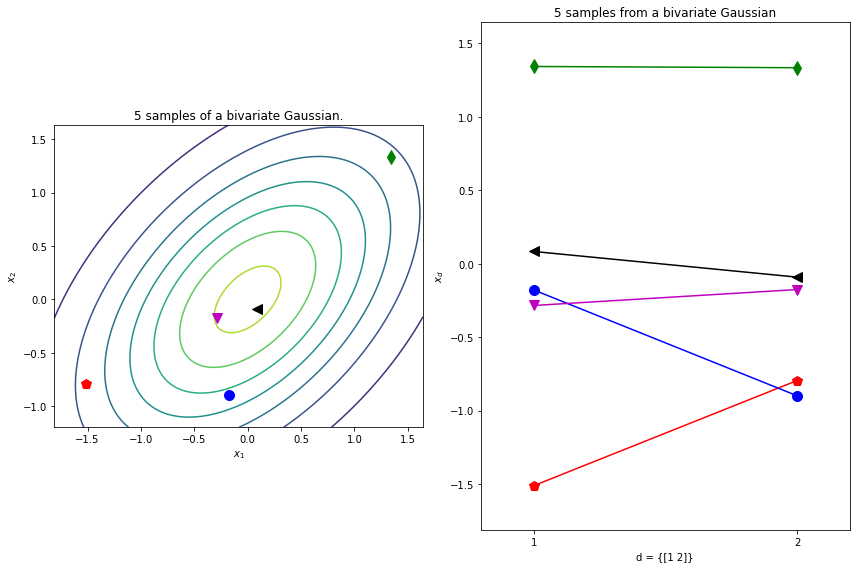

In [3]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N=5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian

# Generate samples
np.random.seed(10)
samples = gen_Gaussian_samples(mu,sigma,N) 

f=plt.figure(figsize=(12,8)); 
ax1=plt.subplot(1, 2, 1,autoscale_on=True, aspect='equal')
#set_limits(samples)
plot_Gaussian_contours(samples[:,0],samples[:,1],mu,sigma)

# Plot samples
for i in np.arange(N):
    ax1.plot(samples[i,0],samples[i,1], color=colors[i], marker=markers[i],ms=10)
ax1.set_title(f'{N} samples of a bivariate Gaussian.')

ax2=plt.subplot(1, 2, 2,autoscale_on=True)#, aspect='equal')
ax2.set_xticks([1,2])
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)

f.tight_layout()

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one which with strongly correlated dimensions and one with weak correlations

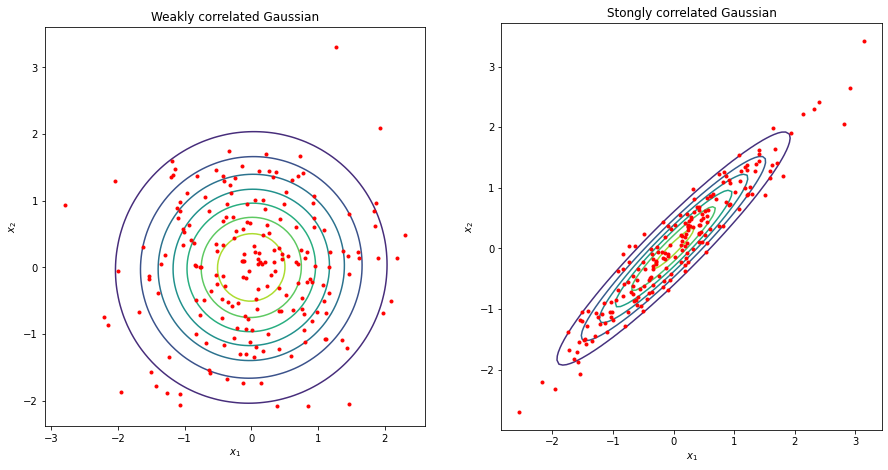

In [5]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f=plt.figure(figsize=(15,15)); 

ax=plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=gen_Gaussian_samples(mu,sigmaUncor)
plot_Gaussian_contours(samplesUncor[:,0],samplesUncor[:,1], mu, sigmaUncor)
ax.plot(samplesUncor[:,0],samplesUncor[:,1], 'r.')
ax.set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=gen_Gaussian_samples(mu,sigmaCor)
plot_Gaussian_contours(samplesCor[:,0],samplesCor[:,1], mu, sigmaCor)
ax.plot(samplesCor[:,0],samplesCor[:,1], 'r.')
ax.set_title('Stongly correlated Gaussian');

But let's plot them as before dimension-wise...

> Which one is which?

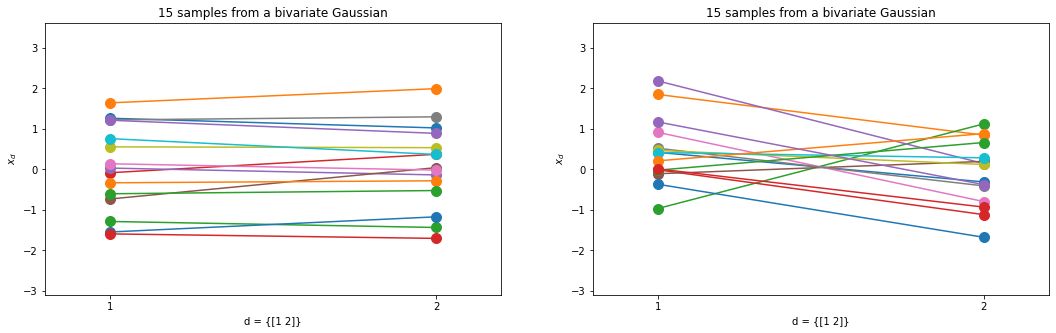

In [6]:
f=plt.figure(figsize=(18,5)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 2); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
ax2=plt.subplot(1, 2, 1,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
if False:
    ax1.set_title('Weakly correlated');
    ax2.set_title('Strongly correlated')
for ax in [ax1,ax2]:
    ax.set_xticks([1,2])
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3]);

* The strongly correlated Gaussian gives more "horizontal" lines in the dimension-wise plot.

* More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. 

* Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

Covariance matrix:
[[ 5.09  5.14  5.15  5.39  5.48  5.56  5.57  5.65]
 [ 5.14  5.23  5.25  5.68  5.83  5.98  6.    6.16]
 [ 5.15  5.25  5.29  5.76  5.94  6.11  6.13  6.32]
 [ 5.39  5.68  5.76  7.41  8.15  8.94  9.06 10.03]
 [ 5.48  5.83  5.94  8.15  9.23 10.37 10.56 12.03]
 [ 5.56  5.98  6.11  8.94 10.37 11.97 12.23 14.3 ]
 [ 5.57  6.    6.13  9.06 10.56 12.23 12.52 14.69]
 [ 5.65  6.16  6.32 10.03 12.03 14.3  14.69 17.72]]
Eigenvalues all larger than zero
[67.05  7.1   0.27  0.01  0.01  0.    0.01  0.01]


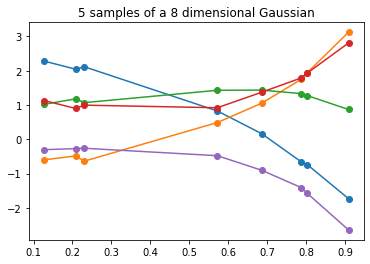

In [7]:
N=5
mu = np.array([0,0,0,0,0,0,0,0])
D = mu.shape[0]

# Generate random covariance matrix
tmp = np.sort(np.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T) + 0.005*np.eye(D)
with np.printoptions(precision=2, suppress=True):
    print('Covariance matrix:')
    print(sigma)
    print('Eigenvalues all larger than zero')
    print(np.linalg.eigvals(sigma))

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-o')

plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

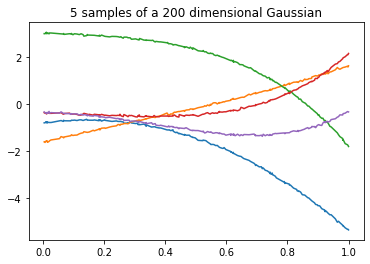

In [8]:
N=5
D=200
mu = np.zeros((D,1))[:,0]

# Generate random covariance matrix
tmp = np.sort(np.random.rand(D))[:,None]
tmp2 = tmp**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T)+ 0.0005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(tmp,samples[i,:], '-')

plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

We see that each sample now starts looking like a "smooth" curve (notice that the random variables are highly correlated). Therefore, we now have a clear intuition as to why a GP can be seen as an *infinite dimensional multivariate Gaussian* which is used as a *prior over functions*, since one sample from a GP is a function.

### Mean and covariance function

Similarly to how a D-dimensional Gaussian is parameterized by its mean vector and its covariance matrix, a GP is parameterized by a mean *function* and a covariance *function*. To explain this, we'll assume (without loss of generality) that the mean function is $\mu(x) = \mathbf{0}$. As for the covariance function, $C(x,x')$, it is a function that receives as input two locations $x,x'$ belonging to the input domain, i.e. $x,x' \in \mathcal{X}$, and returns the value of their co-variance.

In this way, if we have a *finite* set of input locations we can evaluate the covariance function at every pair of locations and obtain a covariance matrix $\mathbf{C}$. We write:

$$
\mathbf{C} = C(\mathbf{x}, \mathbf{x}').
$$

### Covariance functions, aka kernels

We saw above their role for creating covariance matrices from training inputs, thereby allowing us to work with a finite domain when it is potentially infinite.

We'll see below that the covariance function is what encodes our assumption about the GP. By selecting a covariance function, we are making implicit assumptions about the shape of the function we wish to encode with the GP, for example how smooth it is.

Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

Below we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth),

$$
C_\mathrm{RBF}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma_f^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$

where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale*, $\ell$ and the signal variance $\sigma_f^2$. We also note that this kernel is *stationary*, meaning that it only depends on the distance $\left| \mathbf{x}_{i} - \mathbf{x}_{j} \right|$. 

There are many other kinds of kernels. An example of a non-stationary one is the linear kernel:

$$
C_\mathrm{lin}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \mathbf{x}_{i}^T \mathbf{x}_{j}
$$

Below, we will implement and investigate them.

#### The RBF kernel (a.k.a Gaussian)

In [9]:
def RBFkernel(dX, alpha=np.array([1,1])):
    """
    The stationary RBF kernel function for a one-dimension space. 
    
    The distance matrix `dX` can be an arbitrarily shaped numpy array so make sure that you
    use functions like `numpy.exp` for exponentiation.
    
    The hyperparameters `alpha` correspond to [RBF signal variance, RBF correlation length]
    """
    RBF_variance = alpha[0]
    RBF_lengthscale = alpha[1]
    return RBF_variance * np.exp(-0.5*(dX/RBF_lengthscale)**2)

def cov_RBF(X_row, X_col, alpha=np.array([1,1])):
    """
    Construct the covariance matrix for input positions X_row x X_col
        
    Input
    -----
    X_row: list-like, length N_row
    X_col: list_like, length N_col
    alpha: hyperparameters [RBF signal variance, RBF correlation length]
        
    Output
    ------
    Covariance matrix. Shape (N_row, N_col)
    """
    N_row = len(X_row)
    X_row = np.array(X_row).reshape(N_row,1)
    N_col = len(X_col)
    X_col = np.array(X_col).reshape(N_col,1)

    X_row_tile = np.tile(X_row,N_col)
    # dX array is of shape (N_row, N_col)
    dX = X_col.T - X_row_tile
            
    return RBFkernel(dX, alpha=alpha)


def cov_RBF_orig(x, x2=None, alpha=np.array([1,1])):        
        """
        Compute the Euclidean distance between each row of X and X2, or between
        each pair of rows of X if X2 is None and feed it to the kernel.
        """
        variance = alpha[0]
        lengthscale = alpha[1]
        if x2 is None:
            xsq = np.sum(np.square(x),1)
            r2 = -2.*np.dot(x,x.T) + (xsq[:,None] + xsq[None,:])
            r = np.sqrt(r2)/lengthscale
        else:
            x1sq = np.sum(np.square(x),1)
            x2sq = np.sum(np.square(x2),1)
            r2 = -2.*np.dot(x, x2.T) + x1sq[:,None] + x2sq[None,:]
            r = np.sqrt(r2)/lengthscale

        return variance * np.exp(-0.5 * r**2)

Given hyperparameters $\theta$, we plot the resulting covariance matrix and samples from a GP with this covariance function.

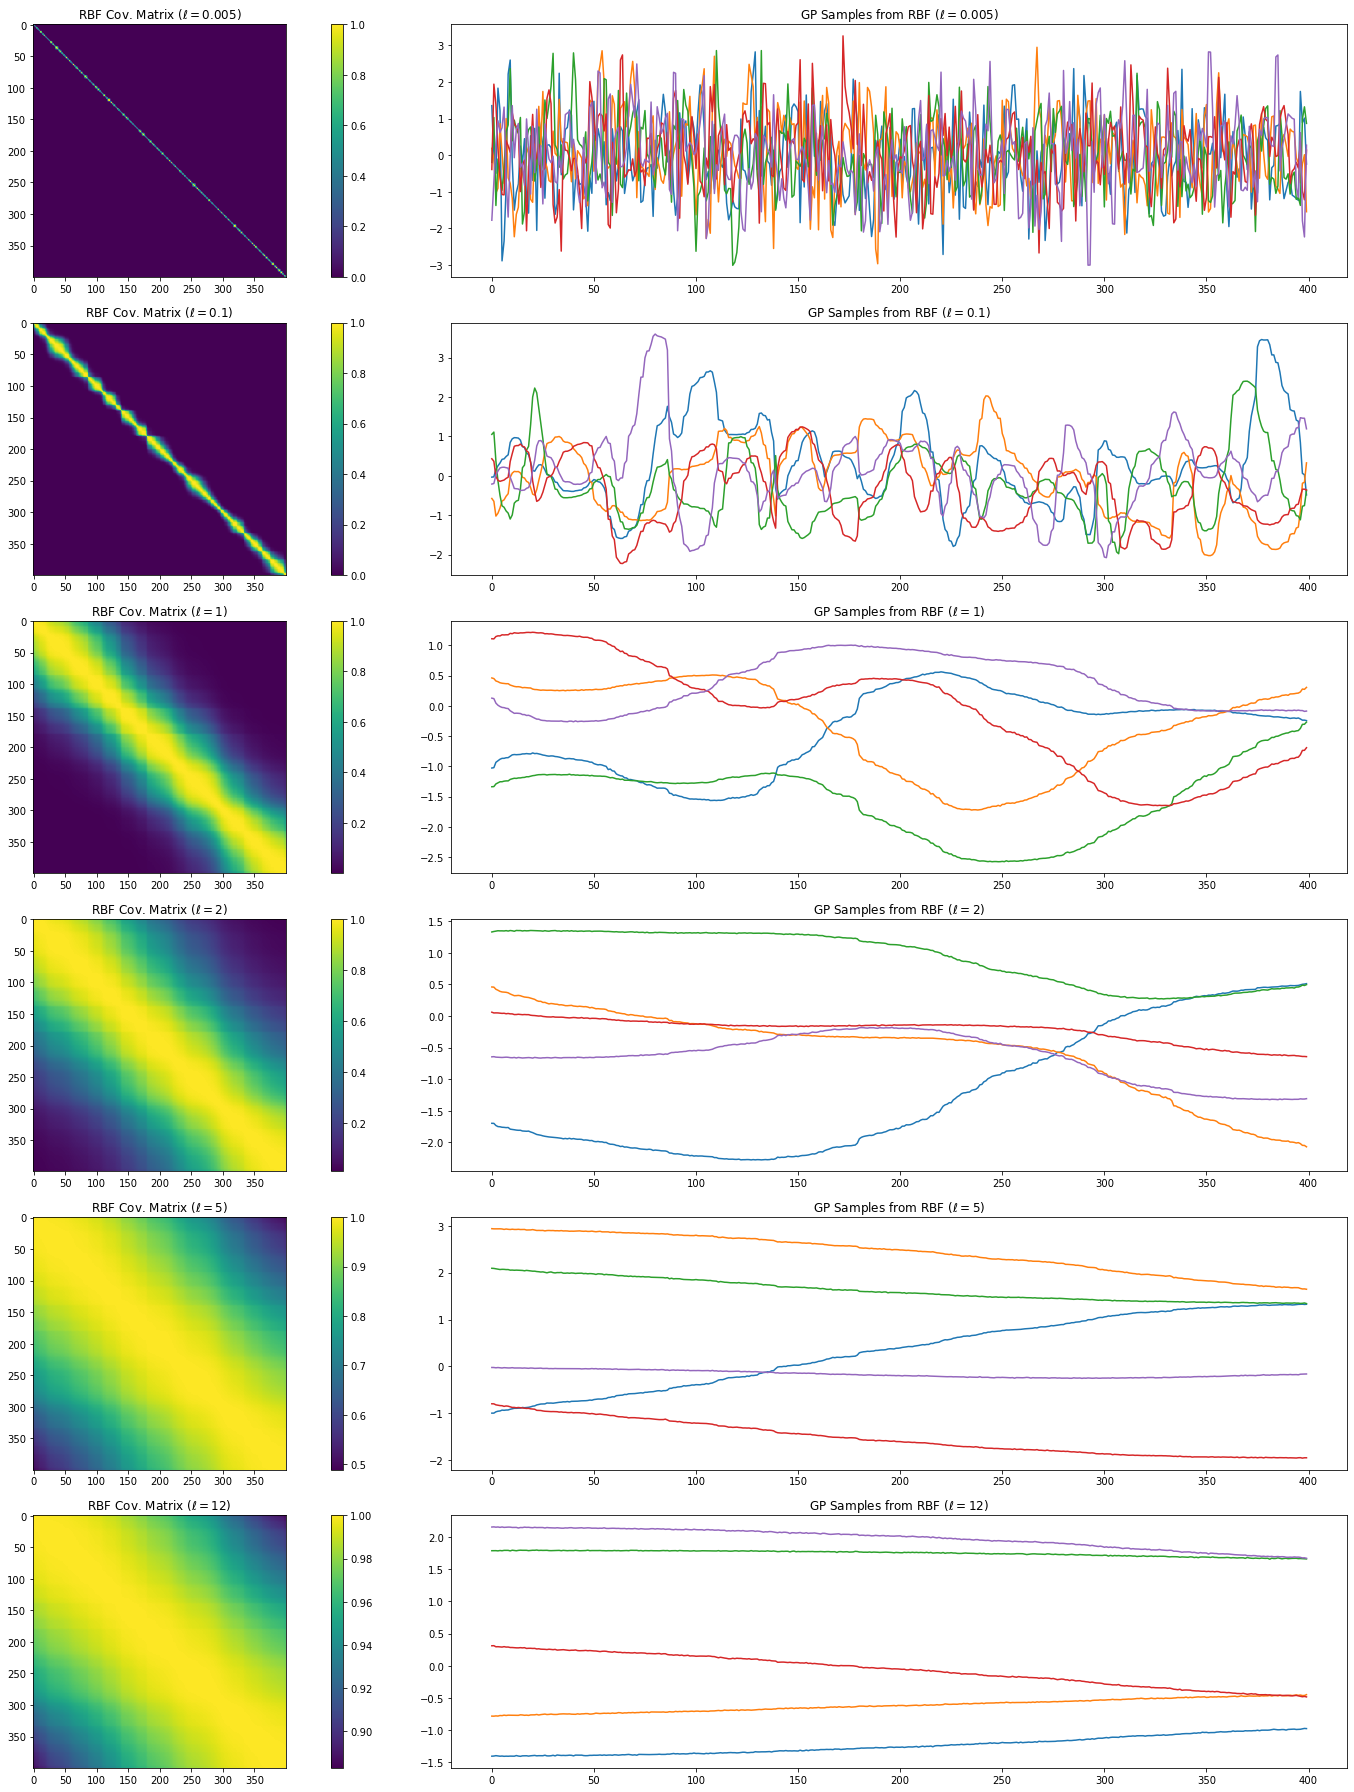

In [10]:
X = np.sort(np.random.rand(400, 1) * 6 , axis=0)

params_rbf    = [0.005, 0.1, 1, 2, 5, 12]
K = len(params_rbf)

num_samples=5
plt.figure(figsize=(25,25))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X,X,alpha=np.array([1,params_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title(rf'RBF Cov. Matrix ($\ell={params_rbf[i]}$)')
    
    plt.subplot(K,2,j+1)
    # Assume a GP with zero mean
    mu=np.zeros((1,K_rbf.shape[0]))[0,:]
    for s in range(num_samples):
        # nugget is a small white noise addition to the diagonal elements to ensure positive definiteness
        nugget = 1e-5*np.eye(K_rbf.shape[0])
        sample = np.random.multivariate_normal(mean=mu, cov=K_rbf+nugget)
        plt.plot(sample)
    plt.gca().set_title(rf'GP Samples from RBF ($\ell={params_rbf[i]}$)')
    j+=2
    
plt.tight_layout()

## Example: GP models for regression
### No-core shell model $\hbar\omega$ dependence

In [ ]:
# import some NCSM data from
# Phys. Rev. C 97, 034328 (2018)
(E,Nmax,hw)=np.loadtxt('data/Li6E_NNLOopt_Nmax10.txt',unpack=True)

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_ylabel(r'$E$ (MeV)');
ax.set_xlabel(r'$\hbar\omega$ (MeV)');
ax.set_title(r'NCSM results for Li-6 energy with NNLOopt at $N_\mathrm{max}=10$')
ax.scatter(hw,E,s=10);

In [ ]:
# Let us scale the target data such that it has mean zero and variance one.
x=hw
mE = np.mean(E)
sE = np.std(E)
y= (E - mE)/sE

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_ylabel(r'$e$');
ax.set_xlabel(r'$x$');
ax.set_title(r'Scaled target data')
ax.scatter(hw,y,s=10);

In [ ]:
# We will test our GP by training on every third data point and validate on the rest.
xt = x[::3, np.newaxis]
yt = y[::3, np.newaxis]

In [ ]:
# Using GP regression functionality from sklearn
import sklearn.gaussian_process as gp_sklearn
# construct an RBF kernel with an initial guess for the hyperparameters
kernel_RBF = gp_sklearn.kernels.ConstantKernel(5.0) * gp_sklearn.kernels.RBF(length_scale=10.0)
# set up the GP regressor
# - use the kernel dunction that we just defined
# - data is already normalized so `normalize_y` should not have an effect
# - use a single start point (the initial guess) when optimizing the hyperparameters (see below)
# - add a fixed white noise
nugget = 1e-6
gpr_sklearn = gp_sklearn.GaussianProcessRegressor(kernel=kernel_RBF, \
                            normalize_y=True, n_restarts_optimizer=0, alpha=nugget)

In [ ]:
# print the initial guess and bounds for GP regressor hyperparameters
params = kernel_RBF.get_params()
for key in sorted(params): print(f"{key} : {params[key]}")

In [ ]:
# Fit kernel hyperparameters
gpr_sklearn.fit(xt, yt)

# Extract and print the optimum values
sigma_f_opt = np.sqrt(gpr_sklearn.kernel_.k1.get_params()['constant_value'])
l_opt = gpr_sklearn.kernel_.k2.get_params()['length_scale']    
print(f'       l = {l_opt:.3f}')
print(f' sigma_f = {sigma_f_opt:.3f}')
print(f'sigma_nu = {nugget}')

In [ ]:
# Utility function for plotting a GP prediction with credible interval
import scipy.stats as stats

def GPplot(X_new, mu_new, cov_new, ax=None, credibility=0.95):
    """
    Plot predictions of the GP regression model.

    Args:
        X_new: New input locations. List-like of length N_new.
        mu_new: GP regressor mean predictions. Array of shape (N_new,1).
        cov_new: GP regressor mean predictions. Array of shape (N_new, N_new).
        ax: Axes handle for plot. Will be created and returned if None. (default None)
        credibility: probability mass to include in the posterior prediction (float<1, default=0.95)
    
    Returns:
        Axes handle
    """
    assert credibility < 1.
    assert credibility > 0.
    # Determine the width of the band
    bandwidth_factor = stats.norm.interval(credibility)[1]
       
    X_new = np.array(X_new).reshape(-1,1)
        
    credible_range_distance = bandwidth_factor * np.sqrt(np.diag(cov_new)).flatten()

    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.fill_between(X_new.flatten(), mu_new.flatten() + credible_range_distance, \
                    mu_new.flatten() - credible_range_distance, alpha=0.1)
    ax.plot(X_new, mu_new, label='Mean')
        
    return ax

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
# Compute posterior mean and covariance at points `xp`
xp = x[:, np.newaxis]
mu_opt, cov_opt = gpr_sklearn.predict(xp, return_cov=True)
GPplot(xp, mu_opt, cov_opt, ax=ax)
# Add all available data
ax.scatter(hw,(E-mE)/sE,s=30,label='test');
ax.scatter(xt,yt,s=50, marker='x', label='train');
ax.set(xlabel=r'$\hbar\omega$ (MeV)',ylabel=r'${e}$ (a.u.)')
ax.set_title(r'GP versus NCSM (scaled energies)')
ax.legend();

In [ ]:
# We will print the largest ratios (predict-true)/predict for the validation data.
ratio_min=1.
ratio_max=1.

for i,yi in enumerate(mu_opt):
    ratio_min=min(ratio_min,np.abs((y[i]+mE)/(yi+mE))[0])
    ratio_max=max(ratio_max,np.abs((y[i]+mE)/(yi+mE))[0])

print(f'Validation result: Ratio true/predict in [{ratio_min:6.4f},{ratio_max:6.4f}]')